In [80]:
# IMPORTING MODULES

from netCDF4 import Dataset
import pickle
from pyproj import Proj, transform
import numpy as np
import numpy.matlib
from scipy.interpolate import RegularGridInterpolator
from datetime import date
import matplotlib.pyplot as plt
from datetime import datetime
import matplotlib
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from smrt import make_snowpack, make_model, sensor_list, make_ice_column

from datetime import timedelta
import sys

from scipy import ndimage

from scipy.ndimage.filters import uniform_filter

from scipy.ndimage.filters import uniform_filter
from scipy.signal import convolve
from scipy import ndimage

def forward_calcH(grain_guess,estimate_tb,thickness,temperature,density,liquid,freq):

    snowpack2 = make_snowpack(thickness,"exponential", density = density, temperature = temperature,corr_length = grain_guess,liquid_water=liquid)
    m = make_model("iba", "dort")
    sensorH = sensor_list.amsr2(freq)
    resH = m.run(sensorH, snowpack2)
#     print('18H brightness temp ',resH.TbH())
    difference = resH.TbH()-estimate_tb
    return resH.TbH()

def forward_calcV(grain_guess,estimate_tb,thickness,temperature,density,liquid,freq):

    snowpack2 = make_snowpack(thickness,"exponential", density = density, temperature = temperature,corr_length = grain_guess,liquid_water=liquid)
    m = make_model("iba", "dort")
    sensorV = sensor_list.amsr2(freq)
    resV = m.run(sensorV, snowpack2)
#     print('18H brightness temp ',resH.TbH())
    difference = resV.TbV()-estimate_tb
    return resV.TbV()

In [10]:
import matplotlib
font = {'size'   : 17}

matplotlib.rc('font', **font)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

In [11]:
grain_guesses = np.arange(0.02,0.752,.02)*10**-3
TBH = np.zeros(grain_guesses.shape)*np.nan
TBV = np.zeros(grain_guesses.shape)*np.nan


for ind,grain_guess in enumerate(grain_guesses):
    TBH[ind],xx = forward_calcH(grain_guess,np.asarray(250.),[60.],[270],[375],0,'18')
    TBV[ind],xx = forward_calcV(grain_guess,np.asarray(250.),[60.],[270],[375],0,'18')


In [12]:
temps = np.arange(243,274,5)
TBH_t = np.zeros(temps.shape)*np.nan
TBV_t = np.zeros(temps.shape)*np.nan


for ind,temp in enumerate(temps):
    TBH_t[ind],xx = forward_calcH([0.25e-3],np.asarray(250.),[60.],[temp],[375],0,'18')
    TBV_t[ind],xx = forward_calcV([0.25e-3],np.asarray(250.),[60.],[temp],[375],0,'18')


In [13]:
densies = np.arange(200,750,10)
TBH_d = np.zeros(densies.shape)*np.nan
TBV_d = np.zeros(densies.shape)*np.nan


for ind,dens in enumerate(densies):
    TBH_d[ind],xx = forward_calcH([0.25e-3],np.asarray(250.),[60.],[270],[dens],0,'18')
    TBV_d[ind],xx = forward_calcV([0.25e-3],np.asarray(250.),[60.],[270],[dens],0,'18')


In [145]:
melts = np.arange(0.0,0.5,0.002)
TB18H_m = np.zeros(melts.shape)*np.nan
TB18V_m = np.zeros(melts.shape)*np.nan
TB36H_m = np.zeros(melts.shape)*np.nan
TB36V_m = np.zeros(melts.shape)*np.nan
TB89H_m = np.zeros(melts.shape)*np.nan
TB89V_m = np.zeros(melts.shape)*np.nan


for ind,melt in enumerate(melts):
    bob=forward_calcH([0.25e-3],np.asarray(250.),[60.],[270],[375],melt,['18H','36H','89H'])
    TB18H_m[ind] = bob[0]
    TB36H_m[ind] = bob[1]
    TB89H_m[ind] = bob[2]

    bob2=forward_calcV([0.25e-3],np.asarray(250.),[60.],[270],[375],melt,['18V','36V','89V'])
    TB18V_m[ind] = bob2[0]
    TB36V_m[ind] = bob2[1]
    TB89V_m[ind] = bob2[2]



In [110]:
# 0 =(1/layer_thickness) WH^2 ^2 + 375/(917*layer_thickness) WH – LW 

lt = 4 
b = (375/917)*lt
a = 1
c = -melts

WH=(-b + np.sqrt(b**2 - 4*a*c))/(2*a)


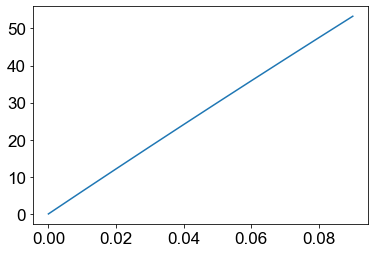

In [114]:
plt.plot(melts,WH*10**3)

In [57]:
bob2[0][1]

<xarray.DataArray ()>
array(269.68152842)
Coordinates:
    polarization  <U1 'V'
    theta         float64 55.0
    frequency     float64 3.65e+10
Attributes:
    mode:     P

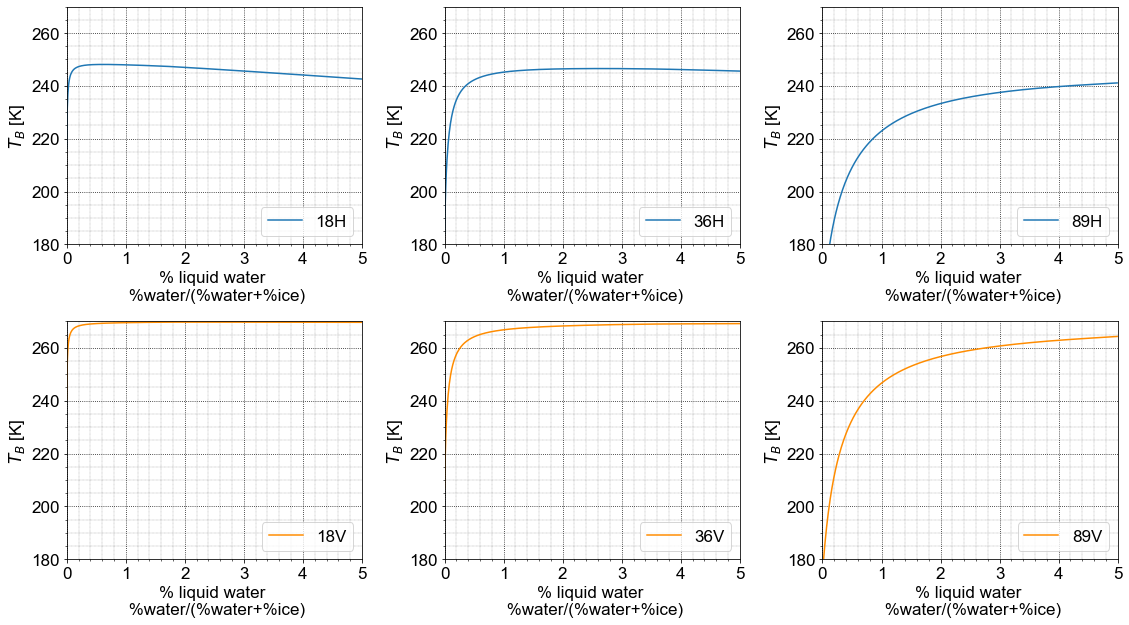

In [137]:
fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(16,9))



lt = 4 
b = (375/917)/lt
a = 1/lt
c = -melts
WH_18=(-b + np.sqrt(b**2 - 4*a*c))/(2*a)*10**3
lt = 2.5
b = (375/917)/lt
a = 1/lt
c = -melts
WH_36=(-b + np.sqrt(b**2 - 4*a*c))/(2*a)*10**3
lt = 0.5 
b = (375/917)/lt
a = 1/lt
c = -melts
WH_89=(-b + np.sqrt(b**2 - 4*a*c))/(2*a)*10**3


ax1.plot(melts*100.,TB18H_m,label='18H')
ax4.plot(melts*100.,TB18V_m,label='18V',color='darkorange')
ax2.plot(melts*100.,TB36H_m,label='36H')
ax5.plot(melts*100.,TB36V_m,label='36V',color='darkorange')
ax3.plot(melts*100.,TB89H_m,label='89H')
ax6.plot(melts*100.,TB89V_m,label='89V',color='darkorange')


for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.minorticks_on()
    ax.grid(which='minor', linestyle=':', linewidth='0.3', color='black')
    ax.grid(which='major', linestyle=':', linewidth='0.8', color='black')
    ax.legend(loc='lower right')
    ax.set_xlabel('% liquid water \n %water/(%water+%ice)')
    ax.set_ylabel('$T_B$ [K]')
    ax.set_xlim([0.,5.])
    ax.set_ylim([180,270])
plt.tight_layout()

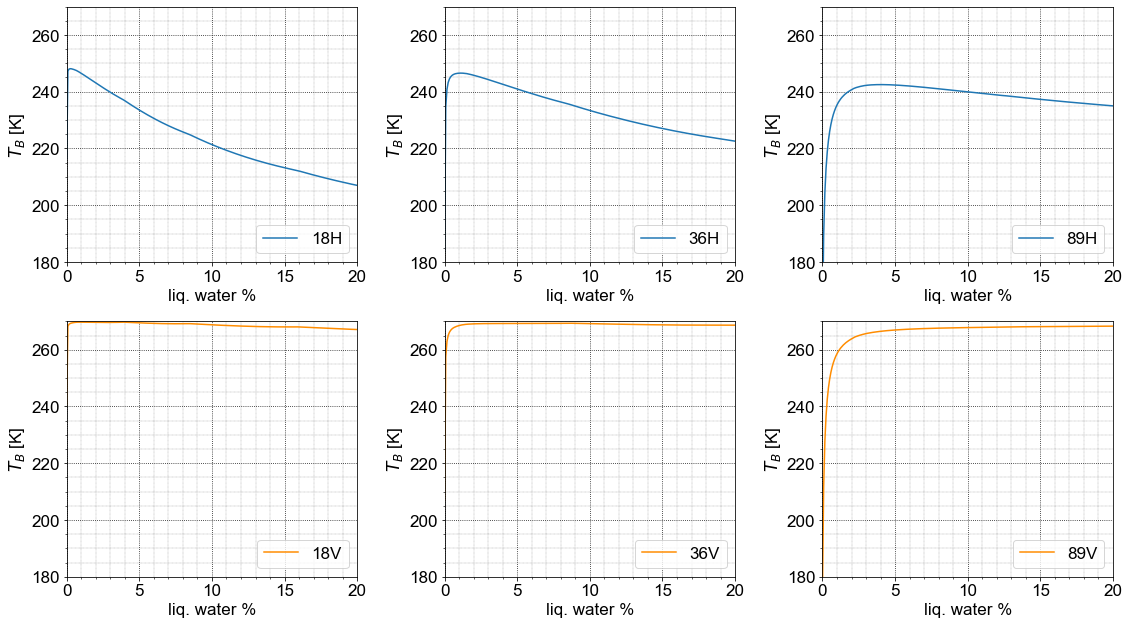

In [148]:
##### fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(16,9))

fig,((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(16,9))


lt = 4 
b = (375/917)/lt
a = 1/lt
c = -melts
WH_18=(-b + np.sqrt(b**2 - 4*a*c))/(2*a)*10**3
lt = 2.5
b = (375/917)/lt
a = 1/lt
c = -melts
WH_36=(-b + np.sqrt(b**2 - 4*a*c))/(2*a)*10**3
lt = 0.5 
b = (375/917)/lt
a = 1/lt
c = -melts
WH_89=(-b + np.sqrt(b**2 - 4*a*c))/(2*a)*10**3


percent_lw=(melts*(375/917))/(1-melts)

ax1.plot(percent_lw*100.,TB18H_m,label='18H')
ax4.plot(percent_lw*100.,TB18V_m,label='18V',color='darkorange')
ax2.plot(percent_lw*100.,TB36H_m,label='36H')
ax5.plot(percent_lw*100.,TB36V_m,label='36V',color='darkorange')
ax3.plot(percent_lw*100.,TB89H_m,label='89H')
ax6.plot(percent_lw*100.,TB89V_m,label='89V',color='darkorange')


for ax in [ax1,ax2,ax3,ax4,ax5,ax6]:
    ax.minorticks_on()
    ax.grid(which='minor', linestyle=':', linewidth='0.3', color='black')
    ax.grid(which='major', linestyle=':', linewidth='0.8', color='black')
    ax.legend(loc='lower right')
    ax.set_xlabel('liq. water %')
    ax.set_ylabel('$T_B$ [K]')
    ax.set_xlim([0.,20.])
    ax.set_ylim([180,270])
plt.tight_layout()

In [147]:
TB18H_m[1]

247.25460752767162

In [27]:
bob=forward_calcH([0.25e-3],np.asarray(270.),[60.],[265],[375],melt,['18','36'])

In [30]:
bob[1]

<xarray.DataArray (frequency: 2)>
array([-59.90367609, -92.79876734])
Coordinates:
    polarization  <U1 'H'
    theta         float64 55.0
  * frequency     (frequency) float64 1.87e+10 3.65e+10

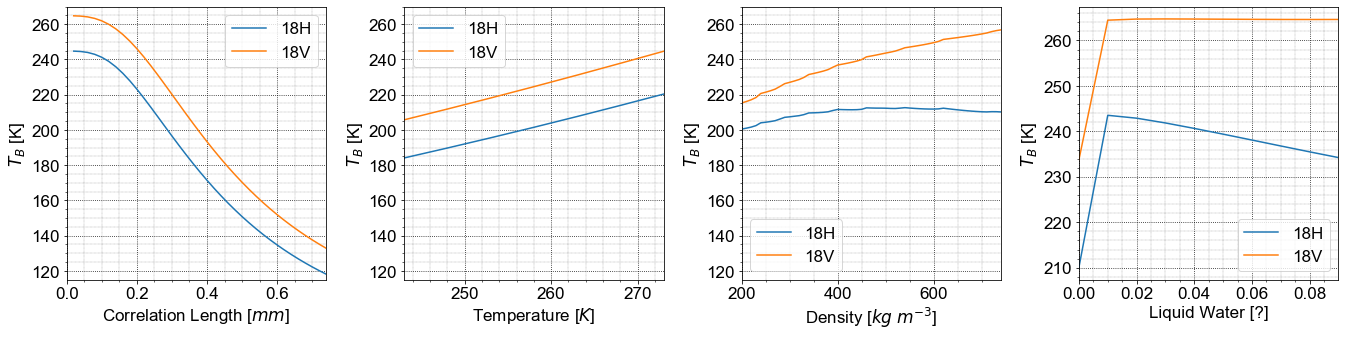

In [22]:
import matplotlib
font = {'size'   : 17}

matplotlib.rc('font', **font)

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']


fig,(ax1,ax2,ax3,ax4) = plt.subplots(1,4,figsize=(19,5))
ax1.plot(grain_guesses*10**3,TBH,label='18H')
ax1.plot(grain_guesses*10**3,TBV,label='18V')
ax1.set_xlim(0.,np.max(grain_guesses*10**3))

ax1.set_xlabel('Correlation Length [$mm$]')
ax1.set_ylabel('$T_B$ [K]')
ax1.set_ylim([115,270])

ax1.legend()

ax2.plot(temps,TBH_t,label='18H')
ax2.plot(temps,TBV_t,label='18V')
ax2.set_xlim(np.min(temps),np.max(temps))
ax2.set_xlabel('Temperature [$K$]')
ax2.set_ylabel('$T_B$ [K]')
ax2.legend()
ax2.set_ylim([115,270])


ax3.plot(densies,TBH_d,label='18H')
ax3.plot(densies,TBV_d,label='18V')
ax3.set_xlim(np.min(densies),np.max(densies))
ax3.set_xlabel('Density [$kg$ $m^{-3}$]')
ax3.set_ylabel('$T_B$ [K]')
ax3.set_ylim([115,270])
ax3.legend()

ax4.plot(melts,TBH_m,label='18H')
ax4.plot(melts,TBV_m,label='18V')
ax4.set_xlim(np.min(melts),np.max(melts))
ax4.set_xlabel('Liquid Water [?]')
ax4.set_ylabel('$T_B$ [K]')
# ax4.set_ylim([115,270])
ax4.legend()

for ax in [ax1, ax2,ax3,ax4]:
    ax.minorticks_on()
    ax.grid(which='minor', linestyle=':', linewidth='0.3', color='black')
    ax.grid(which='major', linestyle=':', linewidth='0.8', color='black')

plt.tight_layout()

plt.savefig('melt_testing.png',dpi=240)



In [20]:
data18V=pickle.load(open('OutputHybrid/Final_Data/Site6_18V.p','rb'))


array([0.])